The goal of this notebook is to understand (and hopefully reconcile) differences between the CLM definition of SMB ("QICE") and the CISM definition ("smb" or "acab"). 

In [1]:
import numpy as np
import math
import sys,os
import xarray as xr

from netCDF4 import Dataset, default_fillvals
from datetime import datetime


In [2]:
import matplotlib.pyplot as plt

# Setup

In [3]:
# Leo's common python files
sys.path.insert(0,'/glade/u/home/lvank/analysis/cesm2_cmip/libpycesm')

# IPython extension to reload modules before executing user code.
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload

%aimport libtimeseries 
%aimport libplot

# Reload all modules imported with %aimport every time before executing the Python code typed.
%autoreload 1

## GrIS ice extent in CLM

Ice extent is computed by combining `PCT_LANDUNIT(3)` and `ICE_MODEL_FRACTION`. 
We're using a restart file from a 1-day dedicated run to output non-default variable `ICE_MODEL_FRACTION`

In [4]:

filename = "/glade/u/home/lvank/work/projects/reconcile_smb/b.e21.BHIST.f09_g17.CMIP6-historical.001_normF.clm2.h0.1850-01-01-00000.nc"
#filename = "/gpfs/fs1/work/lvank/masks/cesm2_fv1/b.e21.BHIST.f09_g17.CMIP6-historical.001_LvK.clm2.h0.1850-01-01-00000.nc"

with xr.open_dataset(filename) as ds:
    imf = ds['ICE_MODEL_FRACTION'][0,:,:].load()
    plu = ds['PCT_LANDUNIT'][0,3,:,:].load()
    lf = ds['landfrac']
    area = ds['area']


In [5]:
# min_lf = min(lf, imf) 
min_lf = xr.where(lf<imf, lf, imf)

In [6]:
cmask_gis = min_lf * plu * 0.01 
#cmask_gis = imf * plu * 0.01 

In [7]:
#cmask_gis.plot()
mma = cmask_gis * area
mma.sum().item()

1798698.75

### FV2 

In [8]:
filename = "/glade/u/home/lvank/work/masks/cesm2_fv2/all.nc"

def print_fv2_area():
    """
    made this a function so that we can reuse the variable names without overwriting them in the body
    """    
    with xr.open_dataset(filename) as ds:
        imf = ds['ICE_MODEL_FRACTION'][0,:,:].load()
        plu = ds['PCT_LANDUNIT'][0,3,:,:].load()
        lf = ds['landfrac']
        area = ds['area'] 
    
    cmask_gis = imf * plu * 0.01 
    mma = cmask_gis * area
    print(mma.sum().item())
    
    min_lf = xr.where(lf<imf, lf, imf)
    cmask_gis = min_lf * plu * 0.01 
    mma = cmask_gis * area
    print('min(lf, imf)', mma.sum().item())
    
print_fv2_area()

1812205.25
min(lf, imf) 1800681.5


## GrIS ice extent in coupler

Using coupler output from a decicated run in which we set `do_histinit = .true.` in the coupler namelist. This generated an extra initial coupler history file. http://www.cesm.ucar.edu/models/cesm2/settings/current/drv_nml.html

In [26]:
#   g2x_nx = 416 ;
#   g2x_ny = 704 ;
#   double g2x_Sg_icemask(time, g2x_ny, g2x_nx) ;
#   double g2x_Sg_icemask_coupled_fluxes(time, g2x_ny, g2x_nx) ;

filename = "/glade/u/home/lvank/work/projects/reconcile_smb/b.e21.BHIST.f09_g17.CMIP6-historical.001_normF.cpl.hi.1850-01-01-00000.nc"

with xr.open_dataset(filename) as ds:

    #foo = ds.g2x_Sg_icemask_coupled_fluxes[0]
    bar = ds.g2x_Sg_icemask[0]
    ic = ds.g2x_Sg_ice_covered[0]
    
    # Cell area from model
    glc_area1 = ds.domg_area.squeeze()
    lnd_area1 = ds.doml_area.squeeze()
    
    # cell area from mapping file
    glc_area2 = ds.domg_aream.squeeze()
    lnd_area2 = ds.doml_aream.squeeze()


ic.shape, glc_area1.shape, glc_area2.shape

((704, 416), (704, 416), (704, 416))

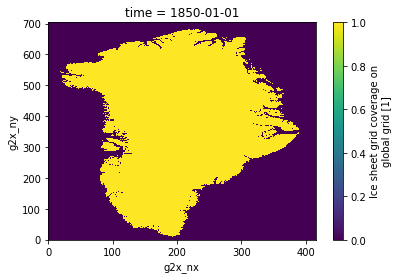

In [27]:
bar.plot()

In [10]:
def area_rad_to_km(area_rad):
    """
    convert area in rad^2 to km^2
    """
    #r_earth = 6371 # radius of earth
    r_earth = 6.37122e3 # SHR_CONST_REARTH, in km 
    circ = 2*np.pi*r_earth

    foo = xr.ufuncs.sqrt(area_rad.copy())
#    foo /= (2*np.pi)
#    foo *= circ
    foo *= r_earth
    area_km = foo**2
    return area_km

In [11]:
glc_area_km1 = area_rad_to_km(glc_area1)
glc_area_km2 = area_rad_to_km(glc_area2)

#glc_area_km1.plot()
glc_area_km1[10,10].item()

16.0

In [12]:
print("constant cell area 16.0 ", ic.sum().item() * 16.)
print("CPL model area", (ic.values * glc_area_km1.values).sum().item() )
print("CPL mapping area", (ic.values * glc_area_km2.values).sum().item() )

constant cell area 16.0  1805616.0
CPL model area 1805616.0
CPL mapping area 1812254.1880229723


Now we will inspect the LND area from the coupler file

In [13]:
# doml_area == doml_aream
diff = lnd_area1-lnd_area2
diff.max().item()

2.710505431213761e-20

## Comparing year 1850 SMB from CISM to that of CLM , to see how large of an effect the slightly larger ice extend in CLM has

The FV1 ice extent in CLM as calculated by `ICE_MODEL_FRACTION * PCT_LANDUNIT(4) * 0.01` was previous stored in variable `mma` which is compared to the CISM extent

In [14]:
mma.sum().item() / (ic.sum().item() * 16.)

0.9961690359411968

i.e. CLM extent is about 0,3 % larger than the CISM extent.

We now consider SMB in the first year from the CMIP6 historical run 001 and compare between CLM and CISM

In [15]:
iyear = 1


def get_clm_smb_from_timeseries(iyear, casename='b.e21.BHIST.f09_g17.CMIP6-historical.001', ys=1850, ye=2014):
    filename = "/glade/collections/cdg/timeseries-cmip6/{casename}/lnd/proc/tseries/month_1/{casename}.clm2.h0.QICE.{ys}01-{ye}12.nc".format(casename=casename, ys=ys, ye=ye)
    with xr.open_dataset(filename) as ds:
        tmp = ds.QICE[iyear*12:(iyear*12+12)] 

    # convert monthly CLM smb to yearly value
    dpm = np.asarray(( 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31))
    smb1850_clm = (tmp[0:12] * dpm[:,np.newaxis,np.newaxis]).sum(dim='time') / 365.
        
    # convert mm/s to mm/year
    sec_in_year = 365 * 86400.
    smb1850_clm *= sec_in_year

    assert(len(smb1850_clm.dims)==2)
    return smb1850_clm



def get_cism_smb_from_timeseries(iyear, casename='b.e21.BHIST.f09_g17.CMIP6-historical.001', ys=1851, ye=2015):
    # CISM 
    filename = "/glade/collections/cdg/timeseries-cmip6/{casename}/glc/proc/tseries/year_1/{casename}.cism.h.smb.{ys}-{ye}.nc".format(casename=casename,ys=ys, ye=ye)
    with xr.open_dataset(filename, decode_times=False) as ds:
        smb1850_cism = ds.smb[iyear]
    assert(len(smb1850_cism.dims)==2)
    return smb1850_cism

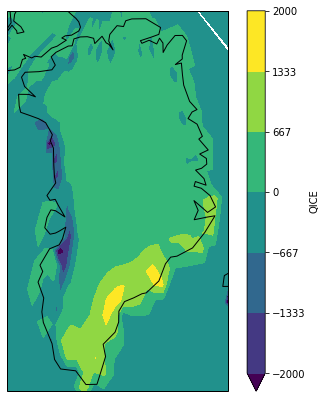

In [16]:
iyear = 0

smb1850_clm = get_clm_smb_from_timeseries(iyear)
import cartopy.crs as ccrs

fig = plt.figure(figsize=(7,7));
ax = libplot.define_greenland_map(fig)
#ax = plt.axes(projection=ccrs.PlateCarree());
smb1850_clm.plot.contourf('lon', 'lat', ax=ax, transform=ccrs.PlateCarree(), vmin=-2000, vmax=2000,)

In [17]:
# some constants
rhoi= 0.917e3
rhow= 1.000e3

fac_Gt = 1e-12
fac_km2 = 1e6

In [18]:
print('GrIS area', (mma).sum().item() )

nyear = 10
ismb_clm = np.zeros(nyear)
ismb_cism = np.zeros(nyear)

for iyear in range(10):
    smb1850_clm = get_clm_smb_from_timeseries(iyear)
    fac = fac_Gt * fac_km2 # mm/yr w.e. to Gt / yr
    ismb_clm[iyear] = (smb1850_clm * mma).sum(dim=('lon','lat')).values * fac
    print(iyear, 'CLM smb', ismb_clm[iyear])

GrIS area 1798698.75
0 CLM smb 501.2310754432559
1 CLM smb 508.61873368284654
2 CLM smb 476.0221137047888
3 CLM smb 596.4661048133432
4 CLM smb 770.9515326362691
5 CLM smb 581.1778425400746
6 CLM smb 646.525686257838
7 CLM smb 641.9774422959925
8 CLM smb 438.5355320278332
9 CLM smb 397.1627347240524


In [19]:
print('GrIS area', (ic.values * glc_area_km2.values).sum() )

for iyear in range(nyear):
    smb1850_cism = get_cism_smb_from_timeseries(iyear)
    
    area_pixel = 16.
    fac = fac_Gt * fac_km2 # mm/yr w.e. to Gt / yr
    #print('No scaling ', (smb1850_cism.values * ic.values).sum() * area_pixel * fac )  #* rhow/rhoi
    #print('rhow/rhoi ', (smb1850_cism.values * ic.values).sum() * area_pixel * fac * rhow/rhoi)
    #print('rhoi/rhow ', (smb1850_cism.values * ic.values).sum() * area_pixel * fac * rhoi/rhow)

    fac = fac_Gt * fac_km2 # mm/yr w.e. to Gt / yr
    ismb_cism[iyear] = (smb1850_cism.values * ic.values * glc_area_km2.values).sum()  * fac
    print(iyear, 'No scaling ',  ismb_cism[iyear])  #* rhow/rhoi

GrIS area 1812254.1880229723
0 No scaling  458.4009167368383
1 No scaling  462.4390515302623
2 No scaling  432.55567839602867
3 No scaling  562.161717026494
4 No scaling  738.1672515068551
5 No scaling  547.8521244003495
6 No scaling  608.1137916267261
7 No scaling  591.4367751861136
8 No scaling  395.9037093915319
9 No scaling  343.8707834025432


In [20]:
(ismb_cism / ismb_clm).mean()

0.9205530074569696

In [21]:
rhoi/rhow

0.917

In [22]:
print('GrIS area', (ic.values * glc_area_km2.values).sum() )

for iyear in range(10):
    smb1850_cism = get_cism_smb_from_timeseries(iyear)
    
    area_pixel = 16.
    fac = fac_Gt * fac_km2 # mm/yr w.e. to Gt / yr
    #print('No scaling ', (smb1850_cism.values * ic.values).sum() * area_pixel * fac )  #* rhow/rhoi
    #print('rhow/rhoi ', (smb1850_cism.values * ic.values).sum() * area_pixel * fac * rhow/rhoi)
    #print('rhoi/rhow ', (smb1850_cism.values * ic.values).sum() * area_pixel * fac * rhoi/rhow)

    fac = fac_Gt * fac_km2 # mm/yr w.e. to Gt / yr
   
    print(iyear, 'scaling rhow/rhoi ', (smb1850_cism.values * ic.values * glc_area_km2.values).sum()  * fac * rhow/rhoi)
    #print('rhoi/rhow ', (smb1850_cism.values * ic.values * glc_area_km2.values).sum() * fac * rhoi/rhow)

GrIS area 1812254.1880229723
0 scaling rhow/rhoi  499.8919484589295
1 scaling rhow/rhoi  504.2955850929796
2 scaling rhow/rhoi  471.7073919258764
3 scaling rhow/rhoi  613.0444024280196
4 scaling rhow/rhoi  804.9806450456435
5 scaling rhow/rhoi  597.4396122141216
6 scaling rhow/rhoi  663.1557160596794
7 scaling rhow/rhoi  644.9692204864924
8 scaling rhow/rhoi  431.73796007800644
9 scaling rhow/rhoi  374.99540174759346


# Sandbox

In [23]:
filename = "/glade/u/home/lvank/work/projects/reconcile_smb/b.e21.BHIST.f09_g17.CMIP6-historical.001_normF.cpl.hi.1850-01-01-00000.nc"

ds = xr.open_dataset(filename)    

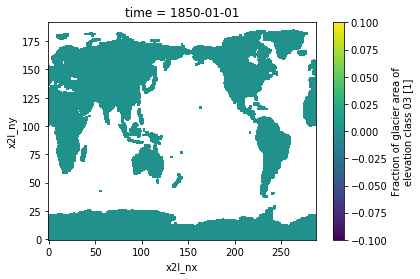

In [24]:

#ds['x2l_Sg_icemask_coupled_fluxes'].plot()
#ds['x2l_Sg_icemask'].plot()
ds['x2l_Sg_ice_covered03'].plot()

#ds['g2x_Sg_icemask'].plot()

In [25]:
np.max(ds['x2l_Sg_ice_covered03'])

<xarray.DataArray 'x2l_Sg_ice_covered03' ()>
array(0.)

**UPDATE**: This has to do with the fact that this coupler history file is written at INITIALIZATION, where it does not contains values (yet). As Bill Sacks wrote:

> Regarding the missing coupler history fields: these should be present and valid every time step (**but maybe not in initialization**), so I'm not sure why you're seeing this. Do you want to point me to a particular cpl hist file showing this issue?

New notebook: `Reconcile icemask+ice_covered.ipynb`